In [1]:
import sys
sys.path.append("../..")
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers

tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
def make_disc_model(nn_list):
    model = tf.keras.Sequential()
    model.add(layers.Dense(nn_list[0]))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(nn_list[1]))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(nn_list[2]))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1,activation='sigmoid'))
    
    return model

def make_gen_model(nn_list,output_dim):
    model = tf.keras.Sequential()
    model.add(layers.Dense(nn_list[0]))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(nn_list[1]))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(nn_list[2]))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(output_dim))

    return model

class T_gen(tf.keras.Model):
    
    def __init__(self,n,m,K_nn_list,F_nn_list):
        super(T_gen,self).__init__(name='T')
        self.n = n
        self.m = m
        self.K = make_gen_model(K_nn_list,n)
        self.F = make_gen_model(F_nn_list,m)
        
    def call(self, inputs):
        x = inputs[...,:self.n]
        y = inputs[...,self.n:]
        T1 = self.K(x)
        T2 = self.F(tf.concat([T1,y],axis=-1))
        
        return tf.concat([T1,T2],axis = -1)

In [5]:
# Using Adam Optimizer for minimizing the Generator and Discriminator loss
import h5py
lr = 1e-5
BATCH_SIZE = 200
BUFFER_SIZE = 10000
n = 3
m = 6
latent_dim = n+m
lamda = 0.01 # monoticity lagrange multiplier 
disc_nn_list = [200,500,100]
K_nn_list = [100,200,100]
F_nn_list = [200,500,100]
N_epochs = 500

from sklearn.preprocessing import MinMaxScaler, StandardScaler
file = h5py.File('BeamSamples.h5','r')
joint_samples1 = np.array(file['Samples/'],dtype=np.float32)
x = joint_samples1[:,n:]
y = joint_samples1[:,:n]
joint_samples = np.concatenate([x,y],axis=-1)
scaler = MinMaxScaler()
scaled_samples = scaler.fit_transform(joint_samples)

NUM_SAMPLES = joint_samples.shape[0]
BATCH_SIZE = 400
dataset = tf.data.Dataset.from_tensor_slices(scaled_samples)
dataset = dataset.shuffle(buffer_size=NUM_SAMPLES).batch(BATCH_SIZE)

f = make_disc_model(disc_nn_list)
T = T_gen(n,m,K_nn_list,F_nn_list)

gen_opt = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-8)
disc_opt = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-8)

def gen_loss():
    z1 = tf.random.normal([BATCH_SIZE,latent_dim])
    z2 = tf.random.normal([BATCH_SIZE,latent_dim])
    T1 = T(z1)
    T2 = T(z2)
    g_loss_fake = tf.reduce_mean(tf.math.log(f(T1)),axis=0)
    m_loss = lamda*tf.reduce_mean(tf.reduce_sum((T1-T2)*(z1-z2),axis=1))
    g_loss = g_loss_fake + m_loss
    return -g_loss

def disc_loss(x):
    z = tf.random.normal([BATCH_SIZE,latent_dim])
    d_loss_real = tf.reduce_mean(tf.math.log(f(x)),axis=0)
    d_loss_fake = tf.reduce_mean(tf.math.log(1.0-f(T(z))),axis=0)
    d_loss = d_loss_real+d_loss_fake
    return -d_loss 
    

# input x is minibatch of data points
@tf.function
def train_step(x): 
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        g_loss = gen_loss()
        d_loss = disc_loss(x)
        
    gen_grad = gen_tape.gradient(g_loss, T.trainable_variables)
    disc_grad = disc_tape.gradient(d_loss, f.trainable_variables)
    
    gen_opt.apply_gradients(zip(gen_grad,T.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad,f.trainable_variables))
    
    return d_loss,g_loss
      
def train(dataset, epochs):
    for epoch in range(epochs):
        for data_batch in dataset:
            d_loss,g_loss = train_step(data_batch)
        if epoch % 10 == 0: 
            print('it:',epoch,"D loss:",d_loss.numpy(),"G loss:",g_loss.numpy())
            
train(dataset,N_epochs)

it: 0 D loss: [1.1295571] G loss: [0.63953644]
it: 10 D loss: [1.3785248] G loss: [0.7044579]
it: 20 D loss: [1.3571615] G loss: [0.69441456]
it: 30 D loss: [1.3832738] G loss: [0.6920562]
it: 40 D loss: [1.3919599] G loss: [0.6798899]
it: 50 D loss: [1.3785834] G loss: [0.66934043]
it: 60 D loss: [1.3756282] G loss: [0.67555386]
it: 70 D loss: [1.3775051] G loss: [0.6636013]
it: 80 D loss: [1.3827636] G loss: [0.65443766]
it: 90 D loss: [1.380032] G loss: [0.7184833]
it: 100 D loss: [1.3791826] G loss: [0.6694497]
it: 110 D loss: [1.3774405] G loss: [0.7372284]
it: 120 D loss: [1.371903] G loss: [0.6993128]
it: 130 D loss: [1.3840632] G loss: [0.7157528]
it: 140 D loss: [1.395494] G loss: [0.6812294]
it: 150 D loss: [1.3894901] G loss: [0.65836835]


KeyboardInterrupt: 

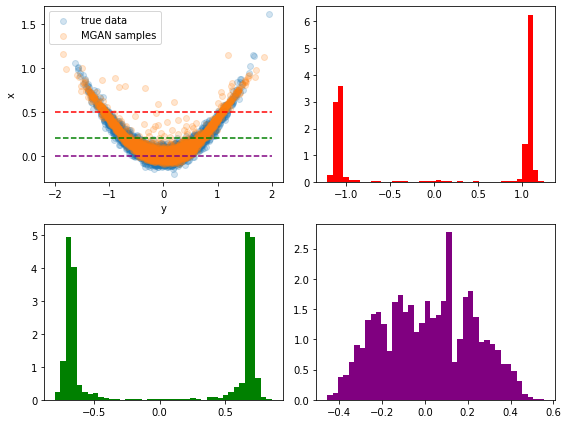

In [5]:
fig, ax = plt.subplots(2,2,figsize=(8,6))
x_obs_list = [0.5,0.2,0.0]
ax[0,0].scatter(X[:,0],X[:,1],alpha=0.2,label='true data')
ax[0,0].scatter(X_flipped[:,0],X_flipped[:,1],alpha=0.2,label='MGAN samples')
ax[0,0].plot(np.linspace(-2,2,100),x_obs_list[0]*np.ones(100),'r--')
ax[0,0].plot(np.linspace(-2,2,100),x_obs_list[1]*np.ones(100),'g--')
ax[0,0].plot(np.linspace(-2,2,100),x_obs_list[2]*np.ones(100),'--',c='purple')
ax[0,0].set(xlabel='y',ylabel='x')
ax[0,0].legend()

Ns = 2000
u = tf.random.normal([Ns,1])

x_obs = x_obs_list[0]*tf.ones([Ns,m])
y_sample1 = T.F(tf.concat([x_obs1,u],axis=-1))[...,0]
y_sample2 = T.F(tf.concat([x_obs2,u],axis=-1))[...,0]
y_sample3 = T.F(tf.concat([x_obs3,u],axis=-1))[...,0]
ax[0,1].hist(y_sample1,40,color='r',density=True)
ax[1,0].hist(y_sample2,40,color='g',density=True)
ax[1,1].hist(y_sample3,40,color='purple',density=True)
plt.tight_layout()
plt.savefig('MGAN_conditional_samples.png')

In [ ]:
# unscaling sampled parameters (m1,m2,m3)
data_min = scaler.data_min_[:num_params]
data_max = scaler.data_max_[:num_params]
scale = scaler.scale_[:num_params]
samples_unscaled = samples*(data_max-data_min) + data_min

fig, axs = plt.subplots(1,3,figsize=(15,5))
m1,m2,m3 = tuple(test_values[:num_params])

axs[0].hist(samples_unscaled[:,0],50,density=True)
axs[0].axvline(m1,ymax=0.95,c='r',ls='--',lw=2.0,label='true val')
axs[0].set_xlabel('m1')
axs[0].legend()

axs[1].hist(samples_unscaled[:,1],50,density=True)
axs[1].axvline(m2,ymax=0.95,c='r',lw=2.0,ls='--',label='true val')
axs[1].set_xlabel('m2')
axs[1].legend()

axs[2].hist(samples_unscaled[:,2],50,density=True)
axs[2].axvline(m3,ymax=0.95,c='r',lw=2.0,ls='--',label='true val')
axs[2].set_xlabel('m3')
axs[2].legend()

plt.suptitle('Number of Samples: %d\n Acceptance Rate: %0.3f \n Time: %0.2f s'%(niters,acc_rate,time_total))
plt.subplots_adjust(top=0.85)

plt.savefig('MGAN-Euler_Beam.png')